,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color
0,34.721005,-83.747718,456.8,NaN,NaN,0.000000,0.000000,NaN,0.000000,"[68, 1, 84, 255]"
1,34.721078,-83.747737,457.2,0.000073,-0.000019,8.383447,0.008383,0.4,4.771307,"[68, 1, 84, 255]"
2,34.721153,-83.747754,457.4,0.000075,-0.000017,8.546871,0.016930,0.2,2.340038,"[68, 1, 84, 255]"
3,34.721228,-83.747769,457.4,0.000075,-0.000015,8.500499,0.025431,0.0,0.000000,"[68, 1, 84, 255]"
4,34.721303,-83.747781,457.6,0.000075,-0.000012,8.441444,0.033872,0.2,2.369263,"[68, 1, 84, 255]"


running generic dbscan
eps=0.01, min_samples=10, Silhouette Score: -1.00
eps=0.01, min_samples=20, Silhouette Score: -1.00
eps=0.01, min_samples=30, Silhouette Score: -1.00
eps=0.01, min_samples=100, Silhouette Score: -1.00
eps=0.01, min_samples=200, Silhouette Score: -1.00
eps=0.01, min_samples=500, Silhouette Score: -1.00
eps=0.05, min_samples=10, Silhouette Score: -0.19
eps=0.05, min_samples=20, Silhouette Score: -1.00
eps=0.05, min_samples=30, Silhouette Score: -1.00
eps=0.05, min_samples=100, Silhouette Score: -1.00
eps=0.05, min_samples=200, Silhouette Score: -1.00
eps=0.05, min_samples=500, Silhouette Score: -1.00
eps=0.1, min_samples=10, Silhouette Score: -0.51
eps=0.1, min_samples=20, Silhouette Score: -0.04
eps=0.1, min_samples=30, Silhouette Score: -1.00
eps=0.1, min_samples=100, Silhouette Score: -1.00
eps=0.1, min_samples=200, Silhouette Score: -1.00
eps=0.1, min_samples=500, Silhouette Score: -1.00
eps=0.5, min_samples=10, Silhouette Score: -0.17
eps=0.5, min_samples=20, 

KeyError: 'sequential_cluster'

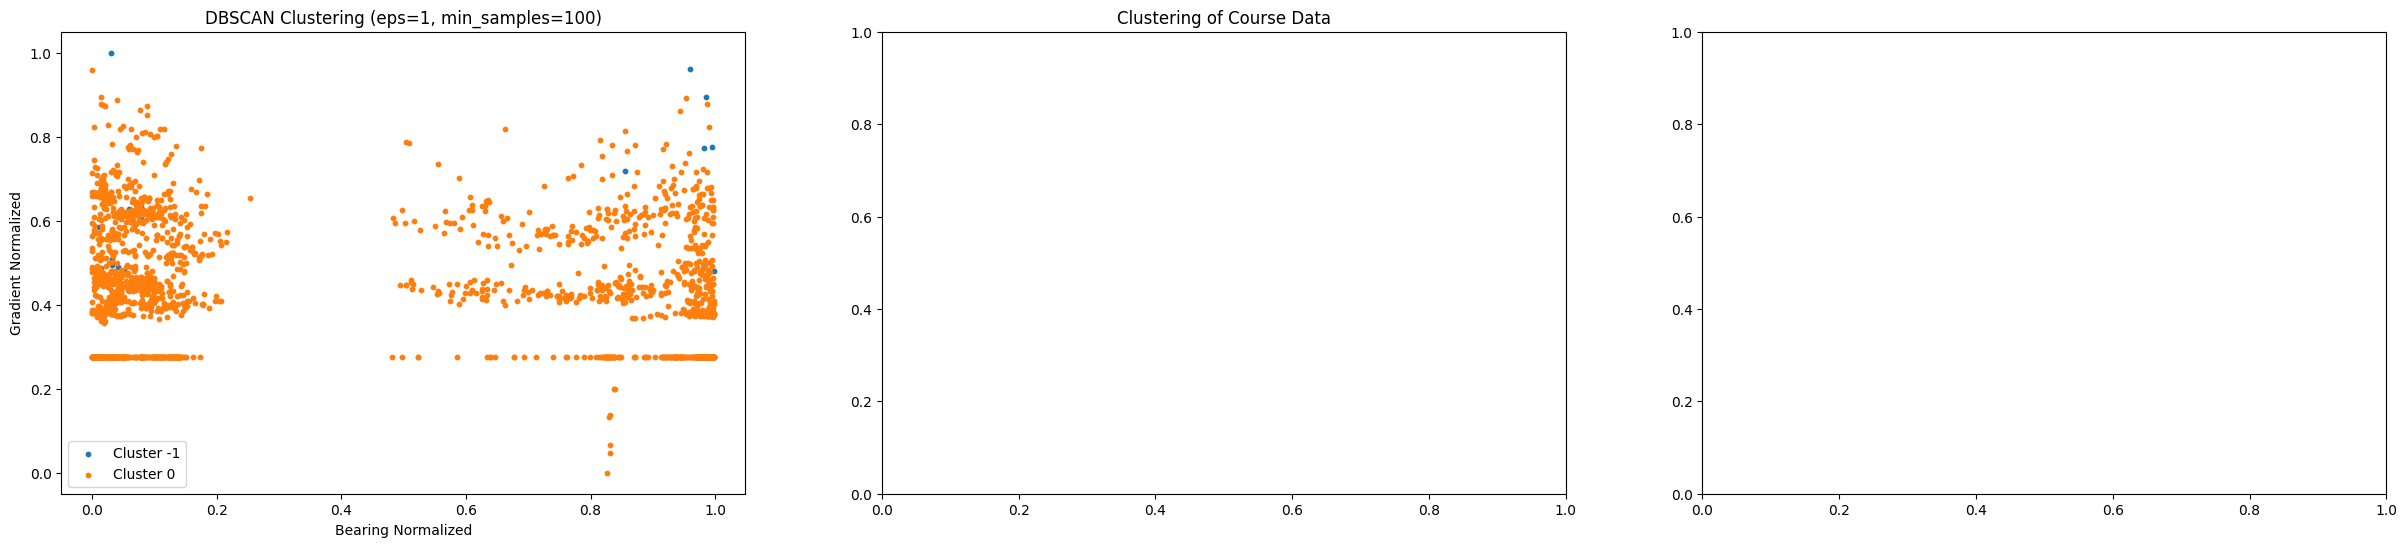

In [18]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from data_proc_helper import *

class DBSCANCluster:
    def __init__(self, df, eps=0.05, min_samples=5, weights=None):
        self.df = df
        self.eps = eps
        self.min_samples = min_samples
        self.weights = weights if weights else {'spatial': 1.0, 'gradient': 0.5, 'bearing': 0.3}
        self.dbscan = None
        self.X = None

    def preprocess_data(self, training_columns=['lat_normalized', 'lon_normalized', 'bearing_normalized', 'gradient_normalized']):
        # Normalize the features to be between 0 and 1
        self.df['gradient'].replace([np.inf, -np.inf], np.nan, inplace=True)
        self.df['gradient'] = self.df['gradient'].fillna(method='ffill')
        
        # Calculate bearing and cardinal direction for each row
        self.df['bearing'] = self.df.apply(lambda row: calculate_bearing(row['lat'], row['lon'], row['lat'], row['lon']) if row.name == 0 else calculate_bearing(self.df.at[row.name-1, 'lat'], self.df.at[row.name-1, 'lon'], row['lat'], row['lon']), axis=1)
        self.df['cardinal_direction'] = self.df['bearing'].apply(bearing_to_cardinal)
        
        # Normalize the features to be between 0 and 1
        self.df['bearing_normalized'] = self.df['bearing'] / 360.0
        self.df['gradient_normalized'] = (self.df['gradient'] - self.df['gradient'].min()) / (self.df['gradient'].max() - self.df['gradient'].min())
        self.df['altitude_normalized'] = (self.df['altitude'] - self.df['altitude'].min()) / (self.df['altitude'].max() - self.df['altitude'].min())
        
        # Fill messed up first row of data
        fill_cols = [col for col in self.df.columns if col.startswith('delta_')]
        fill_cols = fill_cols + ['bearing', 'bearing_normalized', 'cardinal_direction', 'gradient_normalized']
        
        self.df.loc[0, fill_cols] = self.df.loc[1, fill_cols]
        
        # Standardize non-spatial features (gradient, bearing) to have mean=0 and std=1
        scaler = StandardScaler()
        self.df[['scaled_gradient', 'scaled_bearing']] = scaler.fit_transform(self.df[['gradient', 'bearing']])
        
        # Combine latitude and longitude into radians for geospatial distance
        self.df['lat_rad'] = np.radians(self.df['lat'])
        self.df['lon_rad'] = np.radians(self.df['lon'])
        
        self.X = self.df[['lat_rad', 'lon_rad', 'scaled_gradient', 'scaled_bearing']].values

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the Haversine distance between two points on the earth (specified in radians).
        """
        R = 6371.0  # Earth radius in kilometers
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c
        return distance

    def custom_distance(self, x, y):
        """
        Custom distance function combining spatial and non-spatial features with weights.
        Args:
            x: First point (lat_rad, lon_rad, scaled_gradient, scaled_bearing).
            y: Second point (lat_rad, lon_rad, scaled_gradient, scaled_bearing).
        Returns:
            Weighted distance between points.
        """
        # Haversine distance for latitude and longitude
        spatial_distance = self.haversine_distance(x[0], x[1], y[0], y[1])
        
        # Weighted distance for scaled_gradient and scaled_bearing
        gradient_distance = abs(x[2] - y[2])
        bearing_distance = abs(x[3] - y[3])
        
        # Combine distances with weights
        weighted_distance = (
            self.weights['spatial'] * spatial_distance +
            self.weights['gradient'] * gradient_distance +
            self.weights['bearing'] * bearing_distance
        )
        return weighted_distance

    def perform_dbscan(self, eps=None, min_samples=None, plot=True, **kwargs):
        if eps is not None:
            self.eps = eps
        if min_samples is not None:
            self.min_samples = min_samples

        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples, metric=lambda x, y: self.custom_distance(x, y))
        self.df['cluster'] = self.dbscan.fit_predict(self.X)
        
        # Calculate silhouette score
        if len(set(self.df['cluster'])) > 1:
            score = silhouette_score(self.X, self.df['cluster'])
        else:
            score = -1  # Invalid score if only one cluster
        
        if plot:
            self.plot_combined_clusters()
        
        return score

    def plot_combined_clusters(self):
        fig, axes = plt.subplots(1, 3, figsize=(30, 6))

        # Plot clusters based on normalized bearing and gradient
        axes[0].set_title(f'DBSCAN Clustering (eps={self.eps}, min_samples={self.min_samples})')
        for cluster in np.unique(self.df['cluster']):
            clustered_data = self.df[self.df['cluster'] == cluster]
            axes[0].scatter(clustered_data['bearing_normalized'], clustered_data['gradient_normalized'], label=f'Cluster {cluster}', s=10)
        axes[0].set_xlabel('Bearing Normalized')
        axes[0].set_ylabel('Gradient Normalized')
        axes[0].legend()

        # Plot clusters on the course
        axes[1].set_title('Clustering of Course Data')
        for cluster in np.unique(self.df['sequential_cluster']):
            clustered_data = self.df[self.df['sequential_cluster'] == cluster]
            axes[1].scatter(clustered_data['lon'], clustered_data['lat'], label=f'Cluster {cluster}', s=10)
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        axes[1].legend()

        # Plot cumulative distance vs altitude
        axes[2].set_title('Cumulative Distance vs Altitude')
        axes[2].plot(self.df['cumulative_distance'], self.df['altitude'])
        axes[2].set_xlabel('Cumulative Distance')
        axes[2].set_ylabel('Altitude')

        plt.show()

    def create_sequential_clusters(self):
        unique_clusters = {cluster: idx + 1 for idx, cluster in enumerate(sorted(self.df['cluster'].unique()))}
        self.df['sequential_cluster'] = self.df['cluster'].map(unique_clusters)

    def display_summary_statistics(self):
        if 'sequential_cluster' not in self.df.columns:
            self.create_sequential_clusters()
        summary_stats = self.df.groupby('cluster').agg({
            'lat': ['mean', 'std'],
            'lon': ['mean', 'std'],
            'altitude': ['mean', 'std'],
            'gradient': ['mean', 'std'],
            'bearing': ['mean', 'std']
        }).reset_index()
        display(summary_stats)

    def experiment_with_weights(self, weight_combinations, **kwargs):
        results = []
        for weights in weight_combinations:
            self.weights = weights
            self.preprocess_data()
            print(f"Experimenting with weights: {weights}")
            score = self.perform_dbscan(plot=True, **kwargs)
            results.append((weights, score))
            print(f"Weights: {weights}, Silhouette Score: {score:.2f}")
        return results

# Load the sample data
df = pd.read_csv('data_sample.csv')

# Display the first few rows of the DataFrame
display(df.head())

df_raw = df.copy()

# Define weight combinations to experiment with
'''
So generally speaking we want to tone down spatial weeight a lot and tune up gradient and bearing weights.
[({'spatial': 1.0, 'gradient': 0.5, 'bearing': 0.3}, -0.46962229248969706),
 ({'spatial': 0.1, 'gradient': 0.9, 'bearing': 0.5}, 0.020324906266809422),
 ({'spatial': 1.0, 'gradient': 0.7, 'bearing': 0.2}, -0.45940083095015716),
 ({'spatial': 1.0, 'gradient': 0.3, 'bearing': 0.5}, -0.4670770942918431),
 ({'spatial': 0.8, 'gradient': 0.6, 'bearing': 0.4}, -0.434896752276984)]
'''

db = DBSCANCluster(df)


# Experiment with different weights and print the results
#results = db.experiment_with_weights(weight_combinations)

db.preprocess_data()
print("running generic dbscan")

eps_values = [0.01, 0.05, 0.1, 0.5, 1]
min_samples_values = [10, 20, 30, 100, 200, 500]

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        score = db.perform_dbscan(eps, min_samples, plot=False)
        print(f'eps={eps}, min_samples={min_samples}, Silhouette Score: {score:.2f}')
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)


print(f'Best Silhouette Score: {best_score:.2f} with eps={best_params[0]} and min_samples={best_params[1]}')
db.perform_dbscan(best_params[0], best_params[1], plot=True)


weight_combinations = [
    {'spatial': 0.5, 'gradient': 1.5, 'bearing': 0.2},
    {'spatial': 0.3, 'gradient': 1.7, 'bearing': 0.1},
    {'spatial': 0.2, 'gradient': 1.8, 'bearing': 0.1},
    {'spatial': 0.1, 'gradient': 2.0, 'bearing': 0.1},
    {'spatial': 0.4, 'gradient': 1.6, 'bearing': 0.2}
]

# Experiment with different weights and print the results
results = db.experiment_with_weights(weight_combinations, eps = best_params[0], min_samples=best_params[1])

#db.perform_dbscan(plot=True)
#db.display_summary_statistics()

display(results)

In [ ]:
def smooth_data(df, window_size=3):
    """
    Applies rolling average smoothing to bearing and gradient columns.
    """
    df['bearing_smooth'] = df['bearing'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    df['gradient_smooth'] = df['gradient'].rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    return df

def segment_course(df, bearing_threshold, gradient_threshold):
    """
    Really manual method for segmenting data 
    
    Segments a DataFrame into clusters where course or gradient changes significantly,
    after smoothing data. Returns a new DataFrame with a 'segment' column.

    """
    # Smooth the data to reduce noise
    df = smooth_data(df)

    # Calculate differences on smoothed data
    df['bearing_diff'] = df['bearing_smooth'].diff().fillna(0).abs()
    df['gradient_diff'] = df['gradient_smooth'].diff().fillna(0).abs()

    # Initialize segment IDs
    segment_id = 0
    segments = [segment_id]

    # Loop through rows to assign segment IDs
    for i in range(1, len(df)):
        if (
            df.loc[i, 'bearing_diff'] > bearing_threshold or
            df.loc[i, 'gradient_diff'] > gradient_threshold
        ):
            segment_id += 1
        segments.append(segment_id)

    # Add segment IDs to DataFrame
    df['segment'] = segments

    # Drop helper columns if necessary
    df = df.drop(columns=['bearing_diff', 'gradient_diff', 'bearing_smooth', 'gradient_smooth'])

    return df

In [37]:
def plot_course_clusters(df):
    """
    Plots the course data with clusters colored by segment.
    """
    #plt.figure(figsize=(10, 6))
    #for segment in np.unique(df['segment']):
    #    segmented_data = df[df['segment'] == segment]
    #    plt.scatter(segmented_data['bearing'], segmented_data['gradient'], label=f'Segment {segment}')
    #plt.xlabel('Bearing')
    #plt.ylabel('Gradient')
    #plt.title('Segmentation of Course Data')
    #plt.legend()
    #plt.show()

    
    for cluster in np.unique(df['cluster']):
        clustered_data = df[df['cluster'] == cluster]
        plt.scatter(clustered_data['bearing_normalized'], clustered_data['gradient_normalized'], label=f'Cluster {cluster}')
    plt.xlabel('Bearing Normalized')
    plt.ylabel('Gradient Normalized')
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})\nSilhouette Score: {score:.2f}')
    plt.show()
    plt.figure(figsize=(10, 6))
    for cluster in np.unique(df['cluster']):
        clustered_data = df[df['cluster'] == cluster]
        plt.scatter(clustered_data['lon'], clustered_data['lat'], label=f'Cluster {cluster}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Clustering of Course Data | Number of clusters: ' + str(len(np.unique(df['cluster']))) )
    plt.show()

window size:  1
bearing smooth:  359.1960885649409
gradient smooth max:  80.4782471244129


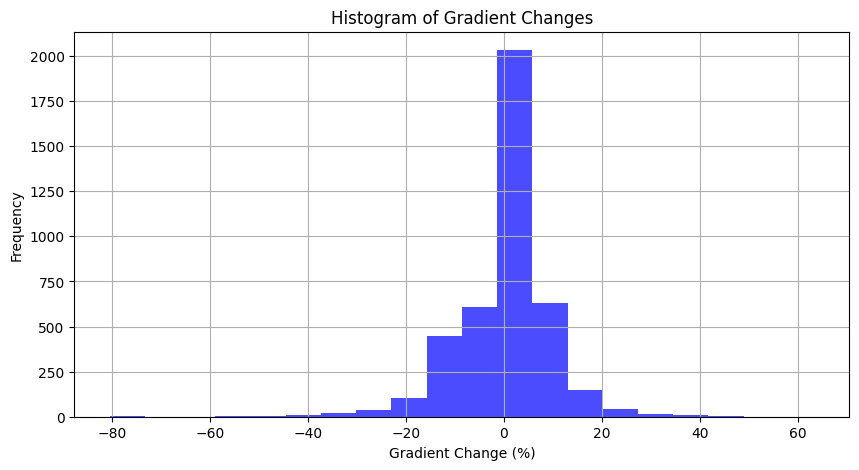

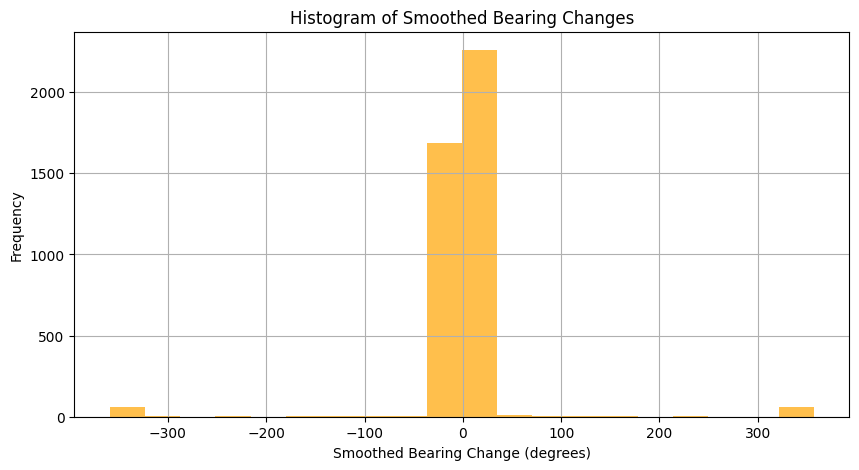

window size:  101
bearing smooth:  3.5435805954722923
gradient smooth max:  0.7968143279644844


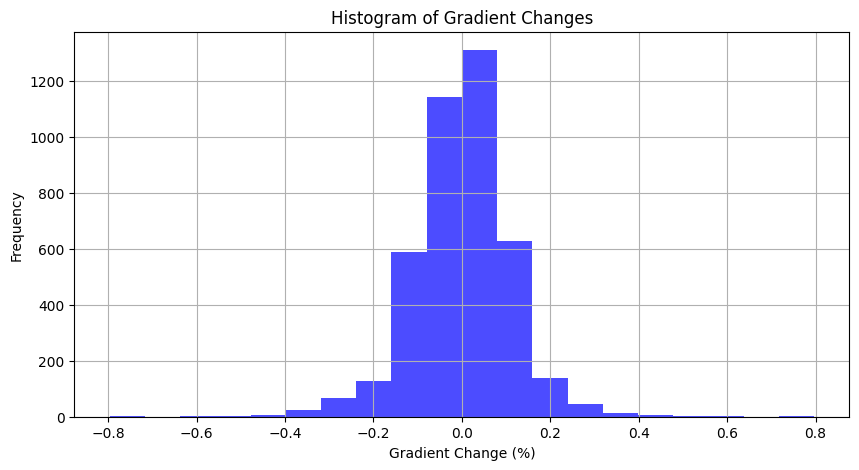

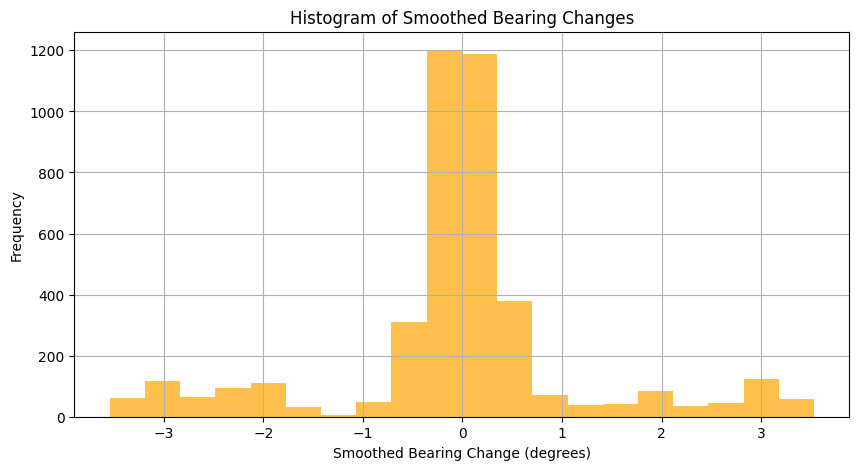

window size:  201
bearing smooth:  1.7776268664769646
gradient smooth max:  0.38843466625996115


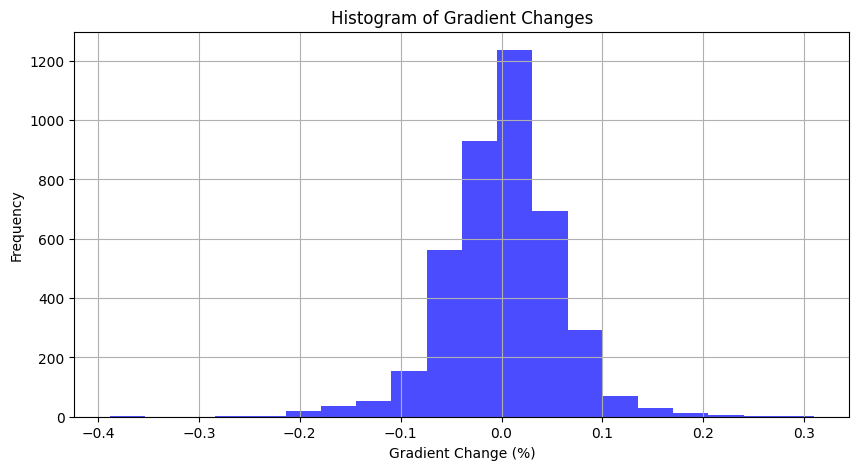

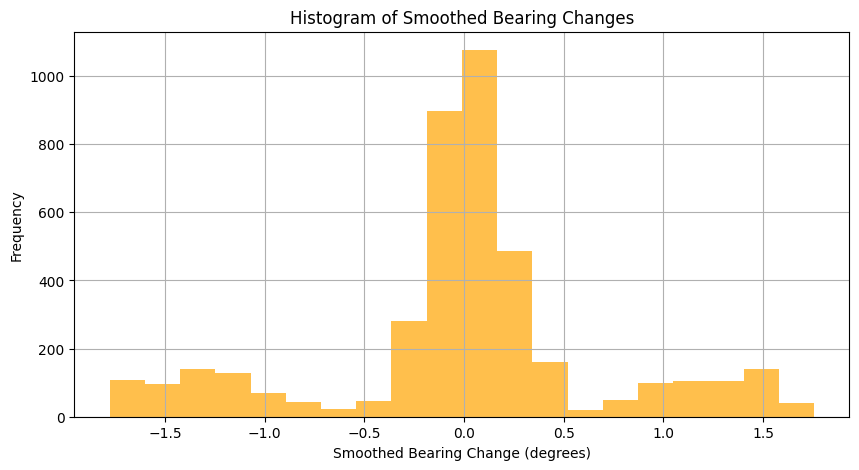

window size:  301
bearing smooth:  1.1933424869266958
gradient smooth max:  0.2673695917754557


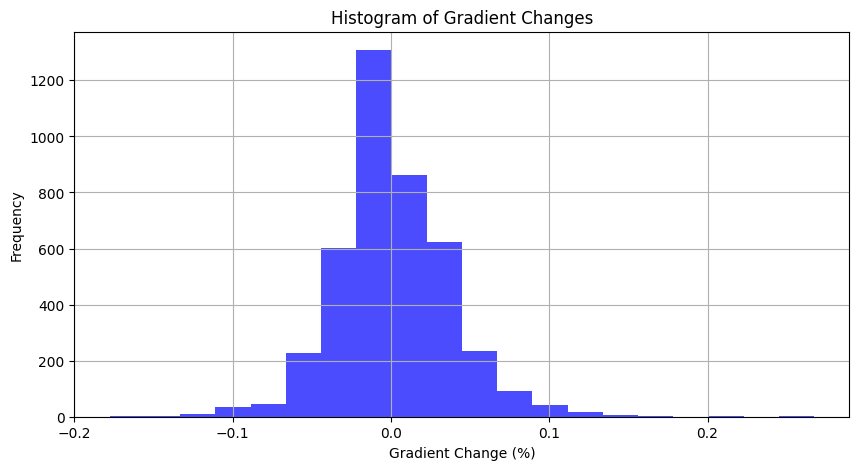

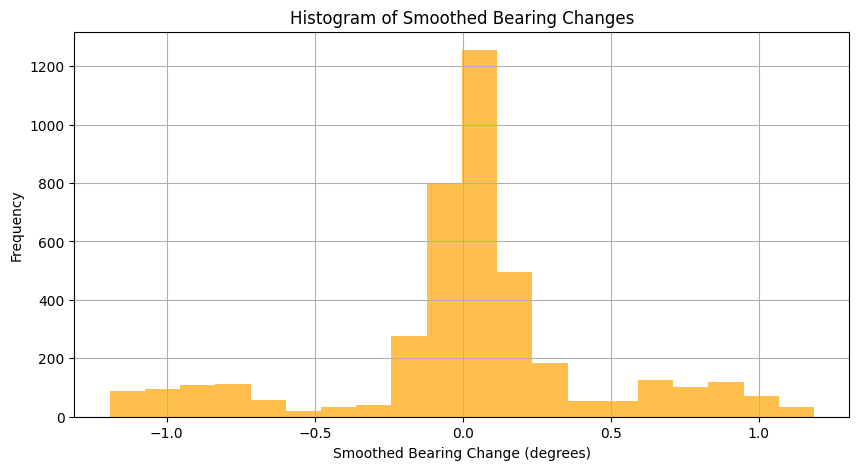

In [ ]:
for i in range(1, 401,100):
    df = smooth_data(df, i)
    print("window size: ", i)
    
    print("bearing smooth: ", df.bearing_smooth.diff().fillna(0).abs().max())
    print("gradient smooth max: ", df.gradient_smooth.diff().fillna(0).abs().max())

        plt.figure(figsize=(10, 5))
    plt.hist(df.gradient_smooth.diff().fillna(0), bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Gradient Changes')
    plt.xlabel('Gradient Change (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Smoothed Bearing Changes Histogram
    plt.figure(figsize=(10, 5))
    plt.hist( df.bearing_smooth.diff().fillna(0), bins=20, color='orange', alpha=0.7)
    plt.title('Histogram of Smoothed Bearing Changes')
    plt.xlabel('Smoothed Bearing Change (degrees)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
from data_proc_helper import *

# Load the sample data
df = pd.read_csv('data_sample.csv')

# Clean the 'gradient' column to remove inf values and fill NaNs
df['gradient'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['gradient'] = df['gradient'].fillna(method='ffill')

# Calculate bearing and cardinal direction for each row
df['bearing'] = df.apply(lambda row: calculate_bearing(row['lat'], row['lon'], row['lat'], row['lon']) if row.name == 0 else calculate_bearing(df.at[row.name-1, 'lat'], df.at[row.name-1, 'lon'], row['lat'], row['lon']), axis=1)
df['cardinal_direction'] = df['bearing'].apply(bearing_to_cardinal)

# Normalize the features to be between 0 and 1
df['bearing_normalized'] = df['bearing'] / 360.0
df['gradient_normalized'] = (df['gradient'] - df['gradient'].min()) / (df['gradient'].max() - df['gradient'].min())
df['altitude_normalized'] = (df['altitude'] - df['altitude'].min()) / (df['altitude'].max() - df['altitude'].min())
df['lat_normalized']= (df['lat'] - df['lat'].min()) / (df['lat'].max() - df['lat'].min())
df['lon_normalized']= (df['lon'] - df['lon'].min()) / (df['lon'].max() - df['lon'].min())

#fill messed up first row of data
fill_cols = [col for col in df.columns if col.startswith('delta_')]
fill_cols = fill_cols + ['bearing', 'bearing_normalized', 'cardinal_direction', 'gradient_normalized']
print(fill_cols)
df.loc[0, fill_cols] = df.loc[1, fill_cols]

display(df.head())


# Combine bearing and gradient for clustering
X = df[['bearing_normalized', 'gradient_normalized', 'lat_normalized','lon_normalized']].values

# Function to perform DBSCAN clustering and plot results
def perform_dbscan(eps, min_samples, plots = True):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    df['cluster'] = dbscan.fit_predict(X)
    
    # Calculate silhouette score
    if len(set(df['cluster'])) > 1:
        score = silhouette_score(X, df['cluster'])
    else:
        score = -1  # Invalid score if only one cluster
    
    # Plot the clusters
    plot_course_clusters(df)

    return score, dbscan

# Experiment with different values of eps and min_samples
eps_values = [0.01, 0.05, 0.1]
min_samples_values = [10, 20, 30]

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        score, dbscan = perform_dbscan(eps, min_samples)
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

print(f'Best Silhouette Score: {best_score:.2f} with eps={best_params[0]} and min_samples={best_params[1]}')

# Perform DBSCAN clustering with the best parameters
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1], metric='euclidean')
df['cluster'] = dbscan.fit_predict(X)

# Create a new column with sequential cluster numbers, offset by 1
unique_clusters = {cluster: idx + 1 for idx, cluster in enumerate(sorted(df['cluster'].unique()))}
df['sequential_cluster'] = df['cluster'].map(unique_clusters)

# Plot the clusters on the course
plt.figure(figsize=(10, 6))
for cluster in np.unique(df['sequential_cluster']):
    clustered_data = df[df['sequential_cluster'] == cluster]
    plt.scatter(clustered_data['lon'], clustered_data['lat'], label=f'Cluster {cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Course Data')
#plt.legend()
plt.show()





,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color
0,51.506133,-0.154634,28.4,NaN,NaN,0.000000,0.000000,NaN,0.000000,"[61, 75, 137, 255]"
1,51.506310,-0.154759,28.3,0.000177,-0.000125,24.082567,0.024083,-0.1,-0.415238,"[66, 61, 132, 255]"
2,51.506483,-0.154891,28.2,0.000173,-0.000132,24.184674,0.048267,-0.1,-0.413485,"[70, 47, 124, 255]"
3,51.506653,-0.155031,28.1,0.000170,-0.000140,24.475826,0.072743,-0.1,-0.408566,"[72, 33, 114, 255]"
4,51.506817,-0.155185,28.0,0.000164,-0.000154,25.003064,0.097746,-0.1,-0.399951,"[71, 17, 99, 255]"


['delta_lat', 'delta_lon', 'delta_altitude', 'bearing', 'bearing_normalized', 'cardinal_direction', 'gradient_normalized']


,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color,bearing,cardinal_direction,bearing_normalized,gradient_normalized,altitude_normalized,lat_normalized,lon_normalized
0,51.506133,-0.154634,28.4,0.000177,-0.000125,0.000000,0.000000,-0.1,0.000000,"[61, 75, 137, 255]",336.271249,NNW,0.934087,0.240089,0.227273,0.000000,1.000000
1,51.506310,-0.154759,28.3,0.000177,-0.000125,24.082567,0.024083,-0.1,-0.415238,"[66, 61, 132, 255]",336.271249,NNW,0.934087,0.240089,0.181818,0.036913,0.965875
2,51.506483,-0.154891,28.2,0.000173,-0.000132,24.184674,0.048267,-0.1,-0.413485,"[70, 47, 124, 255]",334.596279,NNW,0.929434,0.240438,0.136364,0.072993,0.929839
3,51.506653,-0.155031,28.1,0.000170,-0.000140,24.475826,0.072743,-0.1,-0.408566,"[72, 33, 114, 255]",332.861048,NNW,0.924614,0.241417,0.090909,0.108446,0.891619
4,51.506817,-0.155185,28.0,0.000164,-0.000154,25.003064,0.097746,-0.1,-0.399951,"[71, 17, 99, 255]",329.695054,NNW,0.915820,0.243132,0.045455,0.142649,0.849577


NameError: name 'plot_course_clusters' is not defined

In [19]:
summary_stats = df.groupby('sequential_cluster').agg({
    'altitude': ['mean', 'std', 'count'],
    'gradient': ['mean', 'std', 'count'],
    'bearing': ['mean', 'std']
}).reset_index()
summary_stats

sequential_cluster     altitude                     gradient              
                             mean         std count       mean        std   
0                  1  1878.488889  528.211411    18  48.971335  14.394170  \
1                  2  1542.303838  407.608791  3413  10.151261   7.828466   
2                  3  1643.547865  549.211463   679   8.962723   7.773031   

            bearing              
  count        mean         std  
0    18  226.881817  128.306741  
1  3413  298.007936   40.682082  
2   679   40.458149   35.298073

<Axes: >

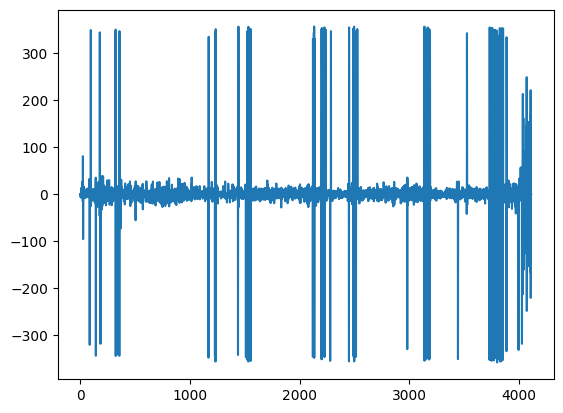

In [15]:
df['bearing'].diff().plot()

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
# df = pd.DataFrame({
#     'lat': [...],
#     'lon': [...],
#     'altitude': [...],
#     'gradient': [...],
#     'bearing': [...]
# })

# Parameters for clustering
distance_eps = 0.001  # Radius for DBSCAN in degrees (~111m per degree of latitude)
min_samples = 2       # Minimum samples for DBSCAN to form a cluster
gradient_threshold = 50  # Threshold for gradient change to trigger a new cluster (adjust as needed)
bearing_threshold = 150  # Threshold for direction change in degrees to trigger a new cluster (adjust as needed)

# Step 1: Apply DBSCAN based on spatial distance
db = DBSCAN(eps=distance_eps, min_samples=min_samples, metric='haversine').fit(np.radians(df[['lat', 'lon']]))
df['initial_cluster'] = db.labels_

# Step 3: Calculate Gradient and Bearing Changes
df['gradient_change'] = df['gradient'].diff().fillna(0)

# Step 4: Smooth Bearing Changes Using a Moving Average
# Calculate the absolute difference in bearings
df['bearing_change'] = df['bearing'].diff().fillna(0).abs()

# Apply a moving average with a window size (e.g., 5)
window_size = 5
df['smoothed_bearing_change'] = (
    df['bearing_change']
    .rolling(window=window_size, center=True)
    .mean()
    .fillna(method='bfill')  # Fill the start of the DataFrame
    .fillna(method='ffill')  # Fill the end of the DataFrame
)

# Step 2: Create final clusters based on direction and gradient change within each DBSCAN cluster
final_clusters = []
current_cluster_id = 0

for cluster_id in df['initial_cluster'].unique():
    if cluster_id == -1:
        # Skip noise points in DBSCAN (if any)
        continue

    # Filter points belonging to the current DBSCAN cluster
    cluster_points = df[df['initial_cluster'] == cluster_id].copy()
    cluster_points.reset_index(drop=True, inplace=True)

    # Initialize the first point as the start of a new sub-cluster
    cluster_points['final_cluster'] = current_cluster_id
    last_gradient = cluster_points.loc[0, 'gradient']
    last_bearing = cluster_points.loc[0, 'bearing']

    for i in range(1, len(cluster_points)):
        # Check if there's a significant change in gradient or bearing
        #gradient_change = abs(cluster_points.loc[i, 'gradient'] - last_gradient)
        bearing_change = abs(cluster_points.loc[i, 'bearing'] - last_bearing)

        if gradient_change > gradient_threshold or bearing_change > bearing_threshold:
            # Start a new cluster if there's a significant change
            current_cluster_id += 1

        # Assign current point to the current (or new) cluster
        cluster_points.loc[i, 'final_cluster'] = current_cluster_id
        last_gradient = cluster_points.loc[i, 'gradient']
        last_bearing = cluster_points.loc[i, 'bearing']

    # Append results to final clusters
    final_clusters.append(cluster_points)
    current_cluster_id += 1

# Concatenate all clusters back into a single DataFrame
df_final = pd.concat(final_clusters, ignore_index=True)



# Step 5: Visualize Gradient and Bearing Changes
# Gradient Changes Histogram
plt.figure(figsize=(10, 5))
plt.hist(df_final['gradient_change'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Gradient Changes')
plt.xlabel('Gradient Change (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Smoothed Bearing Changes Histogram
plt.figure(figsize=(10, 5))
plt.hist(df_final['smoothed_bearing_change'], bins=20, color='orange', alpha=0.7)
plt.title('Histogram of Smoothed Bearing Changes')
plt.xlabel('Smoothed Bearing Change (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 6: Visualize Clusters on a Map (Scatter Plot)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_final['lon'], df_final['lat'], c=df_final['final_cluster'], cmap='viridis', alpha=0.8
)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Course Map')
plt.grid(True)
plt.show()

# Display the final DataFrame
print("Final Clustered Data:")
print(df_final[['lat', 'lon', 'altitude', 'gradient', 'bearing', 'gradient_change', 'smoothed_bearing_change', 'final_cluster']])


KeyError: 'bearing'

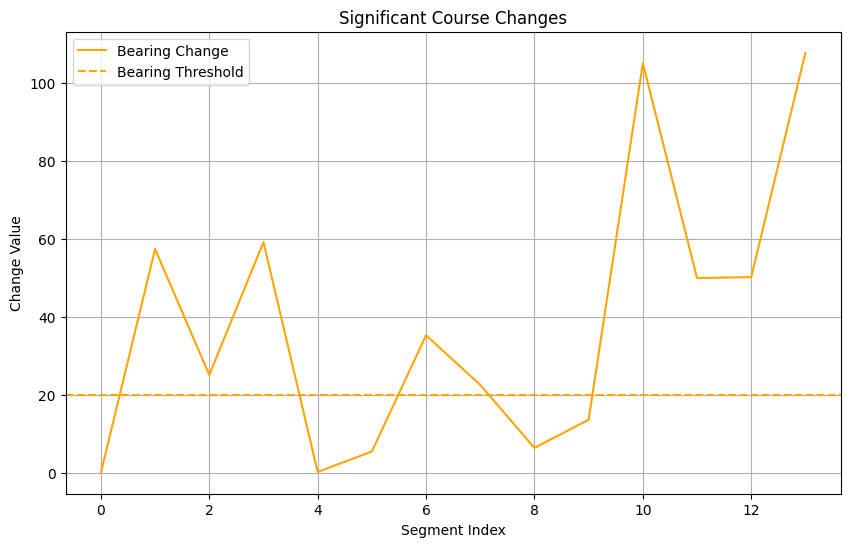

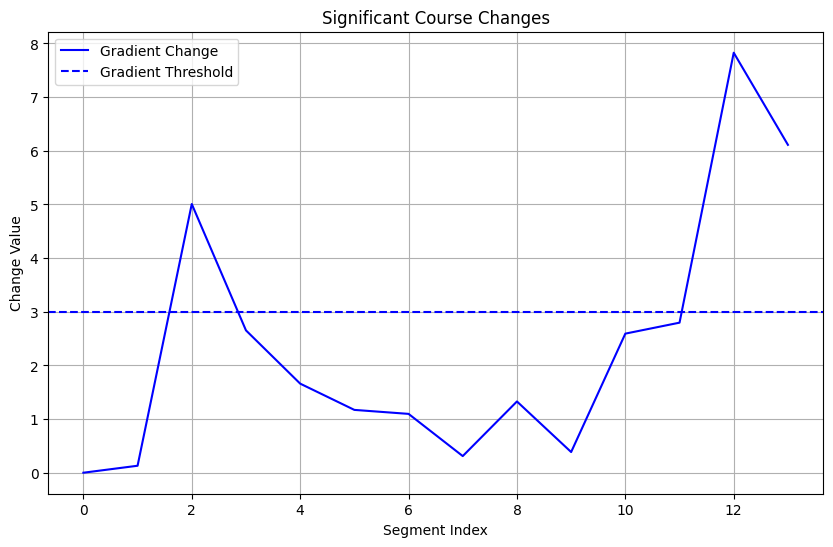

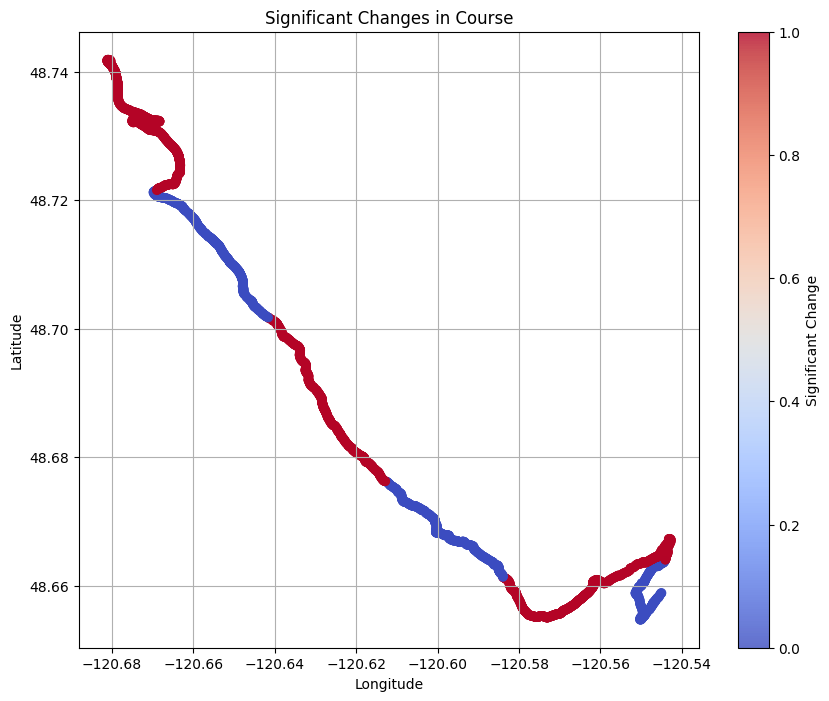

Segments with Significant Changes:
    start_lat   start_lon    end_lat     end_lon  mean_gradient  mean_bearing   
1   48.663990 -120.544164  48.660556 -120.558530       7.600427    206.363347  \
2   48.660537 -120.558632  48.655645 -120.570048      12.607147    231.440228   
3   48.655636 -120.570093  48.661393 -120.583821       9.954851    290.587787   
6   48.676212 -120.612746  48.687965 -120.628132       8.368818    320.206573   
7   48.687999 -120.628148  48.701668 -120.641448       8.678922    297.681386   
10  48.721601 -120.668985  48.730009 -120.667450      12.213013    185.402537   
11  48.730044 -120.667497  48.733164 -120.672396       9.416893    235.338516   
12  48.733189 -120.672465  48.740366 -120.679529      17.242983    285.511239   
13  48.740385 -120.679546  48.741677 -120.680934      11.133375    177.786200   

    segment_index  gradient_change  bearing_change  significant_change  
1               1         0.130017       57.372829                True  
2       

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
# df = pd.DataFrame({
#     'lat': [...],
#     'lon': [...],
#     'altitude': [...],
#     'gradient': [...],
#     'bearing': [...]
# })

# Parameters
smoothing_window = 20  # Window size for moving average
segment_size = 300      # Number of points per segment
gradient_change_threshold = 3  # Threshold for significant gradient change (%)
bearing_change_threshold = 20  # Threshold for significant bearing change (degrees)

# Step 1: Smooth the raw data
df['smoothed_lat'] = df['lat'].rolling(window=smoothing_window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df['smoothed_lon'] = df['lon'].rolling(window=smoothing_window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df['smoothed_gradient'] = df['gradient'].rolling(window=smoothing_window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df['smoothed_bearing'] = df['bearing'].rolling(window=smoothing_window, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# Step 2: Divide into segments and calculate aggregated metrics
segments = []
for i in range(0, len(df), segment_size):
    segment = df.iloc[i:i + segment_size]
    segments.append({
        'start_lat': segment['smoothed_lat'].iloc[0],
        'start_lon': segment['smoothed_lon'].iloc[0],
        'end_lat': segment['smoothed_lat'].iloc[-1],
        'end_lon': segment['smoothed_lon'].iloc[-1],
        'mean_gradient': segment['smoothed_gradient'].mean(),
        'mean_bearing': segment['smoothed_bearing'].mean(),
        'segment_index': i // segment_size
    })

# Create a DataFrame for segments
segments_df = pd.DataFrame(segments)

# Step 3: Detect big course changes by comparing segments
segments_df['gradient_change'] = segments_df['mean_gradient'].diff().fillna(0).abs()
segments_df['bearing_change'] = segments_df['mean_bearing'].diff().fillna(0).abs()

segments_df['significant_change'] = (
#    (segments_df['gradient_change'] > gradient_change_threshold) |
    (segments_df['bearing_change'] > bearing_change_threshold)
)

# Step 4: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(segments_df['segment_index'], segments_df['bearing_change'], label='Bearing Change', color='orange')
plt.axhline(y=bearing_change_threshold, color='orange', linestyle='--', label='Bearing Threshold')
plt.legend()
plt.xlabel('Segment Index')
plt.ylabel('Change Value')
plt.title('Significant Course Changes')
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(segments_df['segment_index'], segments_df['gradient_change'], label='Gradient Change', color='blue')
plt.axhline(y=gradient_change_threshold, color='blue', linestyle='--', label='Gradient Threshold')
plt.legend()
plt.xlabel('Segment Index')
plt.ylabel('Change Value')
plt.title('Significant Course Changes')
plt.grid(True)
plt.show()


# Map course changes to the original data
segment_indices = np.repeat(segments_df['segment_index'].values, segment_size)
segment_indices = segment_indices[:len(df)]  # Truncate if there are extra indices

# Assign the segment indices to the original DataFrame
df['segment_index'] = segment_indices

# Map the significant change flag to the original DataFrame
significant_changes = np.repeat(segments_df['significant_change'].values, segment_size)
significant_changes = significant_changes[:len(df)]  # Truncate if there are extra indices

df['significant_change'] = significant_changes

# Highlight points with significant changes
plt.figure(figsize=(10, 8))
plt.scatter(df['lon'], df['lat'], c=df['significant_change'], cmap='coolwarm', alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Significant Changes in Course')
plt.colorbar(label='Significant Change')
plt.grid(True)
plt.show()

# Print segment summary
print("Segments with Significant Changes:")
print(segments_df[segments_df['significant_change']])

# Map course changes to the original data
segment_indices = np.repeat(segments_df['segment_index'].values, segment_size)
segment_indices = segment_indices[:len(df)]  # Truncate if there are extra indices
df['segment_index'] = segment_indices

significant_changes = np.repeat(segments_df['significant_change'].values, segment_size)
significant_changes = significant_changes[:len(df)]  # Truncate if there are extra indices
df['significant_change'] = significant_changes


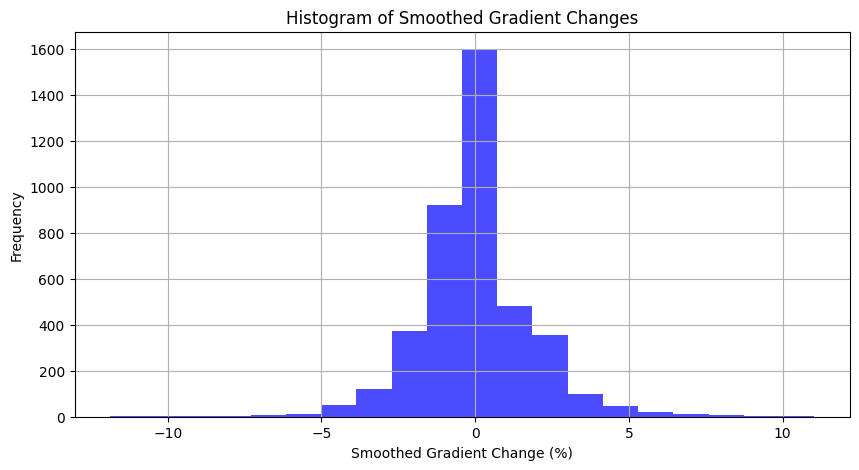

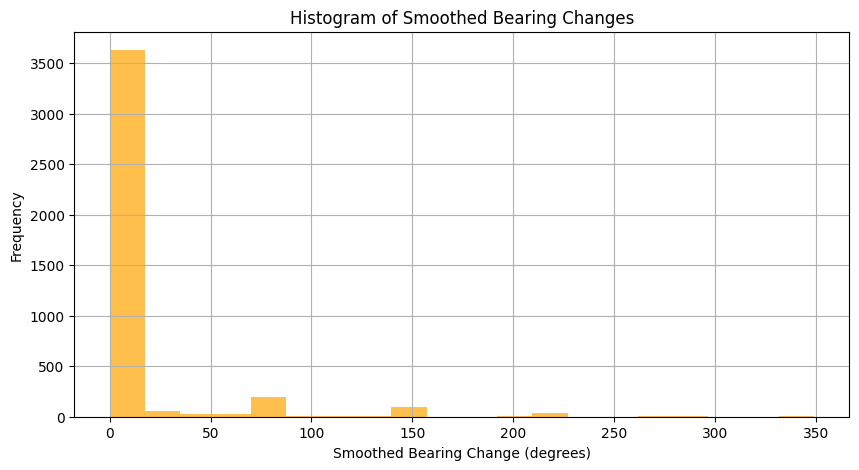

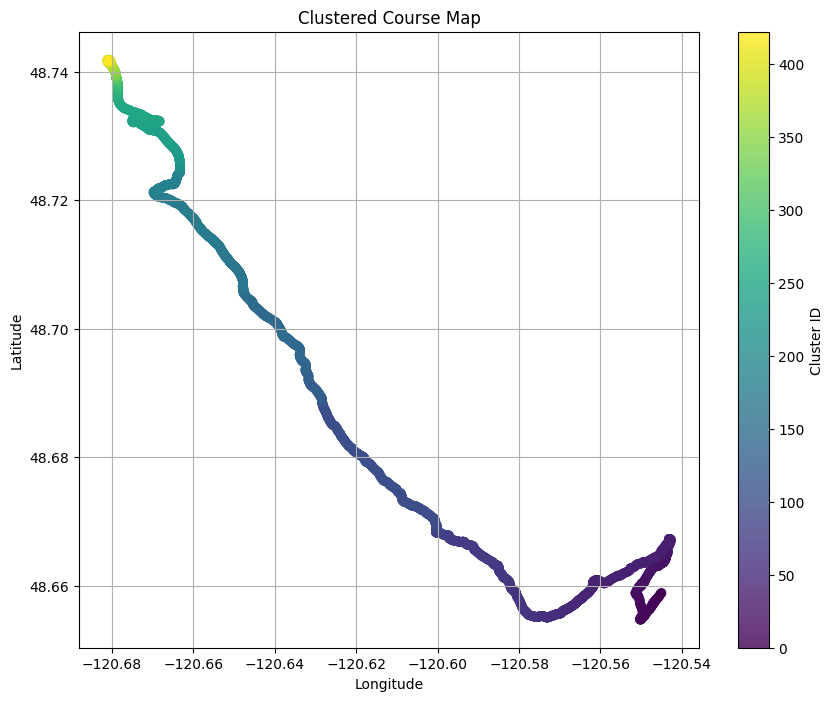

Final Clustered Data:
            lat         lon  altitude  gradient     bearing   
0     48.658872 -120.545005     797.6  0.000000    0.000000  \
1     48.658834 -120.545067     798.0  4.949346  227.142380   
2     48.658796 -120.545123     798.4  5.318152  224.228633   
3     48.658756 -120.545179     798.8  5.229831  222.761399   
4     48.658716 -120.545234     799.4  7.938325  222.247194   
...         ...         ...       ...       ...         ...   
4105  48.741671 -120.680934    2281.6  0.000000    0.000000   
4106  48.741671 -120.680934    2281.6  0.000000    0.000000   
4107  48.741671 -120.680934    2281.6  0.000000    0.000000   
4108  48.741671 -120.680934    2281.6  0.000000    0.000000   
4109  48.741671 -120.680934    2281.6  0.000000    0.000000   

      smoothed_gradient_change  smoothed_bearing_change  final_cluster  
0                     1.587665                46.407513              0  
1                     1.587665                46.407513              0  
2 

In [ ]:
# Parameters for clustering
distance_eps = 0.001  # Radius for DBSCAN in degrees (~111m per degree of latitude)
min_samples = 2       # Minimum samples for DBSCAN to form a cluster
gradient_threshold = 5  # Threshold for gradient change to trigger a new cluster (adjust as needed)
bearing_threshold = 15  # Threshold for direction change in degrees to trigger a new cluster (adjust as needed)

# Step 1: Apply DBSCAN based on spatial distance
db = DBSCAN(eps=distance_eps, min_samples=min_samples, metric='haversine').fit(np.radians(df[['lat', 'lon']]))
df['initial_cluster'] = db.labels_

# Step 2: Create final clusters based on direction and gradient change within each DBSCAN cluster
final_clusters = []
current_cluster_id = 0

for cluster_id in df['initial_cluster'].unique():
    if cluster_id == -1:
        # Skip noise points in DBSCAN (if any)
        continue

    # Filter points belonging to the current DBSCAN cluster
    cluster_points = df[df['initial_cluster'] == cluster_id].copy()
    cluster_points.reset_index(drop=True, inplace=True)

    # Smooth gradients and bearings within this cluster
    cluster_points['gradient_change'] = cluster_points['gradient'].diff().fillna(0)
    cluster_points['bearing_change'] = cluster_points['bearing'].diff().fillna(0).abs()

    # Apply smoothing using a rolling mean with a window size (e.g., 5)
    window_size = 5
    cluster_points['smoothed_gradient_change'] = (
        cluster_points['gradient_change']
        .rolling(window=window_size, center=True)
        .mean()
        .fillna(method='bfill')  # Fill start
        .fillna(method='ffill')  # Fill end
    )
    cluster_points['smoothed_bearing_change'] = (
        cluster_points['bearing_change']
        .rolling(window=window_size, center=True)
        .mean()
        .fillna(method='bfill')  # Fill start
        .fillna(method='ffill')  # Fill end
    )

    # Initialize the first point as the start of a new sub-cluster
    cluster_points['final_cluster'] = current_cluster_id
    last_gradient = cluster_points.loc[0, 'smoothed_gradient_change']
    last_bearing = cluster_points.loc[0, 'smoothed_bearing_change']

    for i in range(1, len(cluster_points)):
        # Check if there's a significant change in smoothed gradient or bearing
        gradient_change = cluster_points.loc[i, 'smoothed_gradient_change']
        bearing_change = cluster_points.loc[i, 'smoothed_bearing_change']

        if abs(gradient_change - last_gradient) > gradient_threshold or abs(bearing_change - last_bearing) > bearing_threshold:
            # Start a new cluster if there's a significant change
            current_cluster_id += 1

        # Assign current point to the current (or new) cluster
        cluster_points.loc[i, 'final_cluster'] = current_cluster_id
        last_gradient = gradient_change
        last_bearing = bearing_change

    # Append results to final clusters
    final_clusters.append(cluster_points)
    current_cluster_id += 1

# Concatenate all clusters back into a single DataFrame
df_final = pd.concat(final_clusters, ignore_index=True)

# Step 3: Visualize Gradient and Bearing Changes
# Gradient Changes Histogram
plt.figure(figsize=(10, 5))
plt.hist(df_final['smoothed_gradient_change'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Smoothed Gradient Changes')
plt.xlabel('Smoothed Gradient Change (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Bearing Changes Histogram
plt.figure(figsize=(10, 5))
plt.hist(df_final['smoothed_bearing_change'], bins=20, color='orange', alpha=0.7)
plt.title('Histogram of Smoothed Bearing Changes')
plt.xlabel('Smoothed Bearing Change (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 4: Visualize Clusters on a Map (Scatter Plot)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_final['lon'], df_final['lat'], c=df_final['final_cluster'], cmap='viridis', alpha=0.8
)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Course Map')
plt.grid(True)
plt.show()

# Display the final DataFrame
print("Final Clustered Data:")
print(df_final[['lat', 'lon', 'altitude', 'gradient', 'bearing', 'smoothed_gradient_change', 'smoothed_bearing_change', 'final_cluster']])


,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color
0,48.658872,-120.545005,797.6,NaN,NaN,0.000000,0.000000,NaN,0.000000,"[68, 1, 84, 255]"
1,48.658834,-120.545067,798.0,-0.000038,-0.000062,8.081876,0.008082,0.4,4.949346,"[68, 1, 84, 255]"
2,48.658796,-120.545123,798.4,-0.000038,-0.000056,7.521409,0.015603,0.4,5.318152,"[68, 1, 84, 255]"
3,48.658756,-120.545179,798.8,-0.000040,-0.000056,7.648431,0.023252,0.4,5.229831,"[68, 1, 84, 255]"
4,48.658716,-120.545234,799.4,-0.000040,-0.000055,7.558269,0.030810,0.6,7.938325,"[68, 1, 84, 255]"


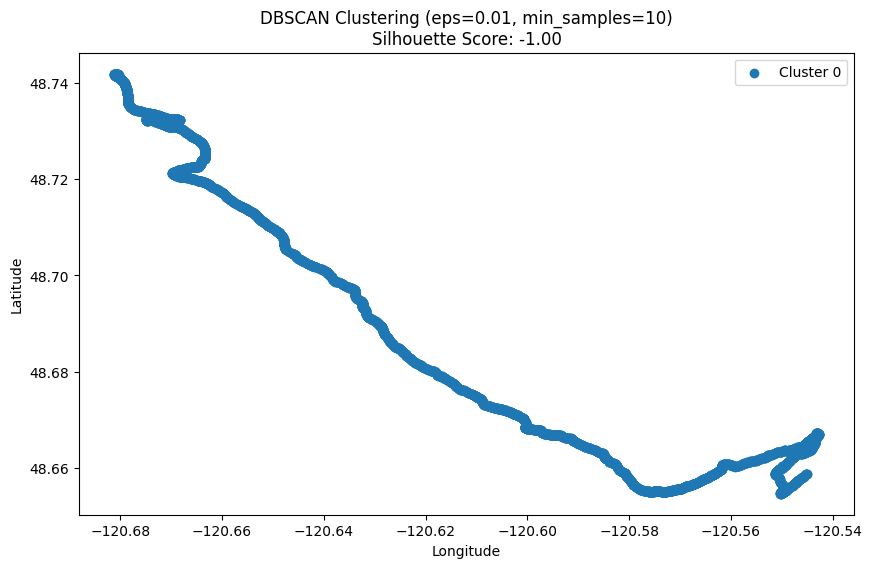

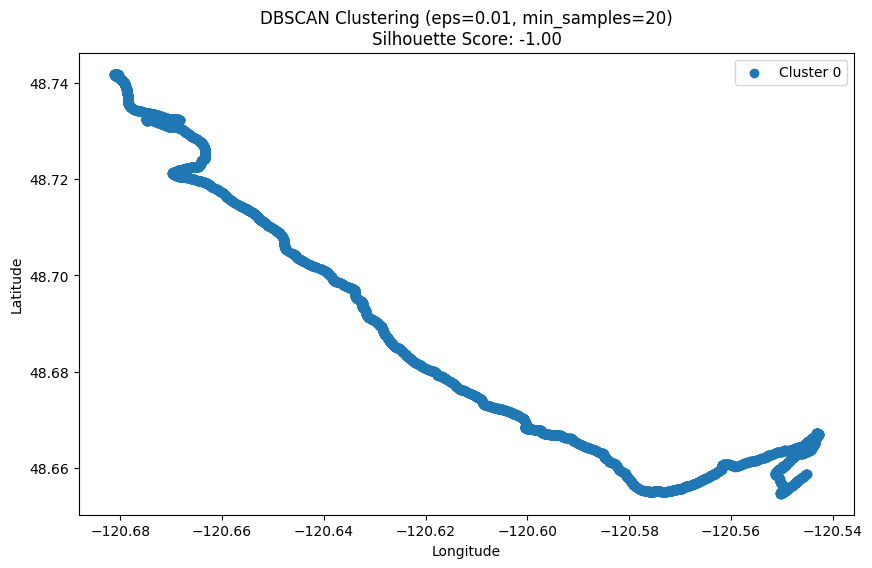

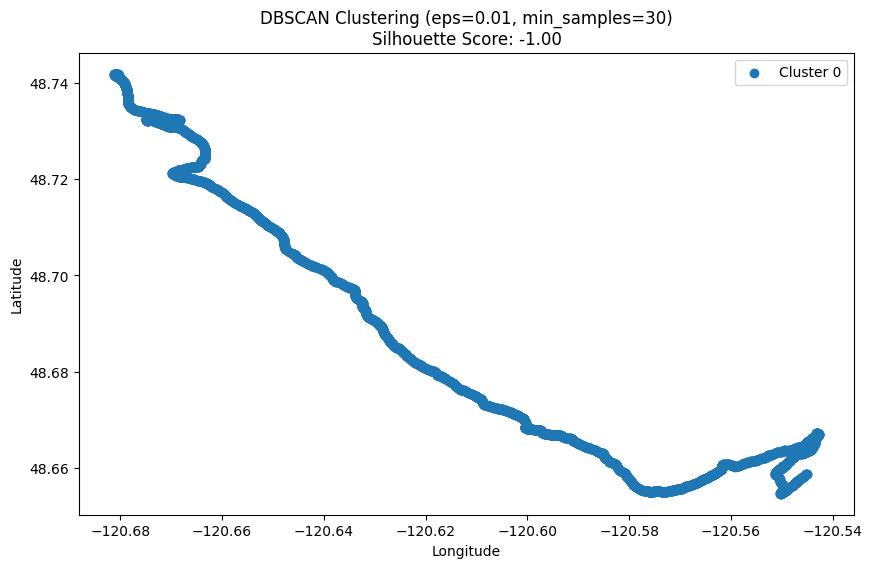

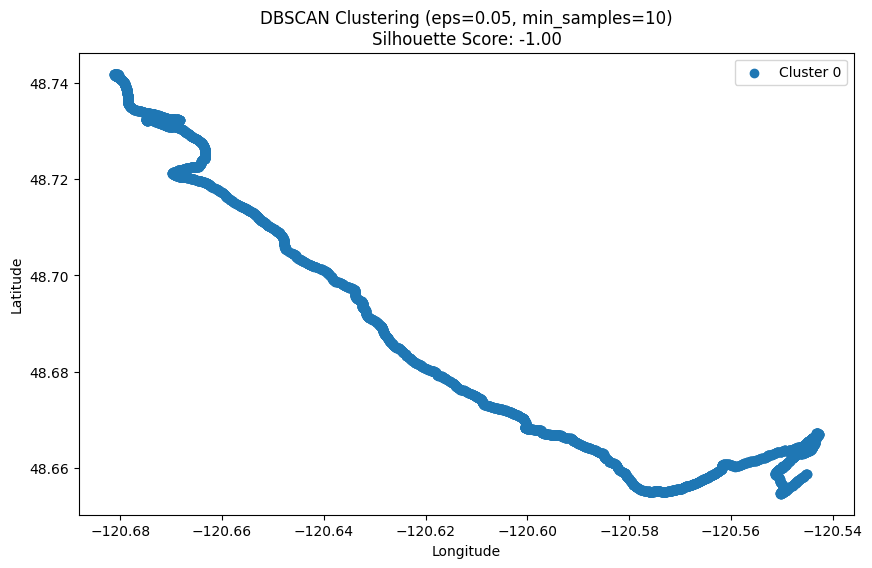

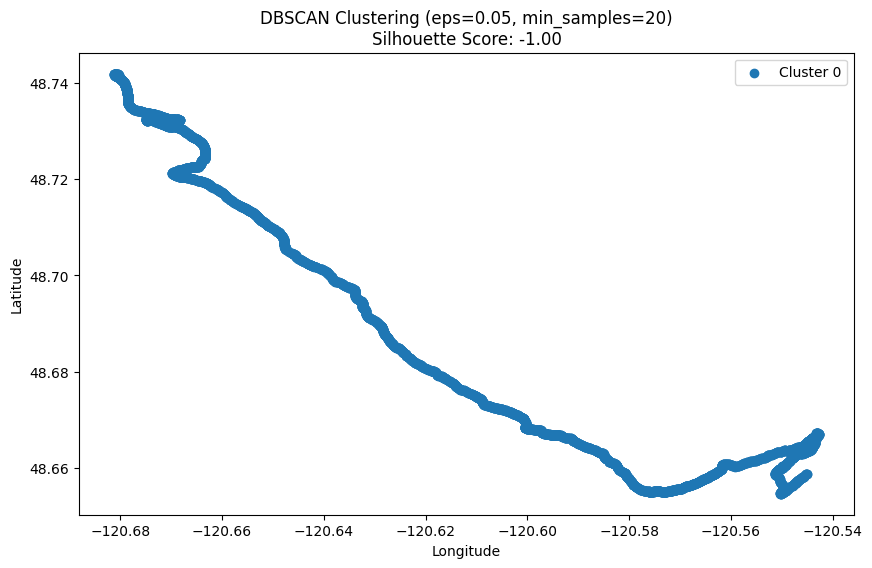

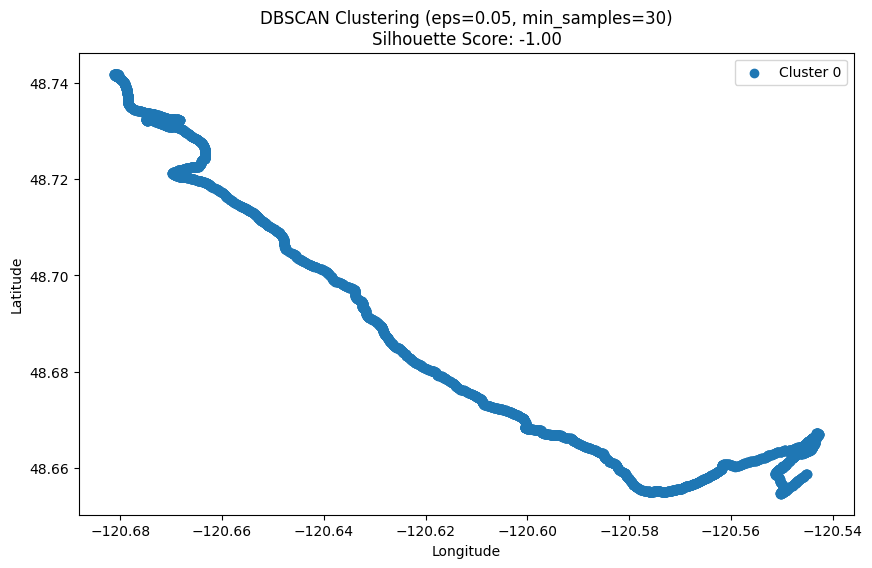

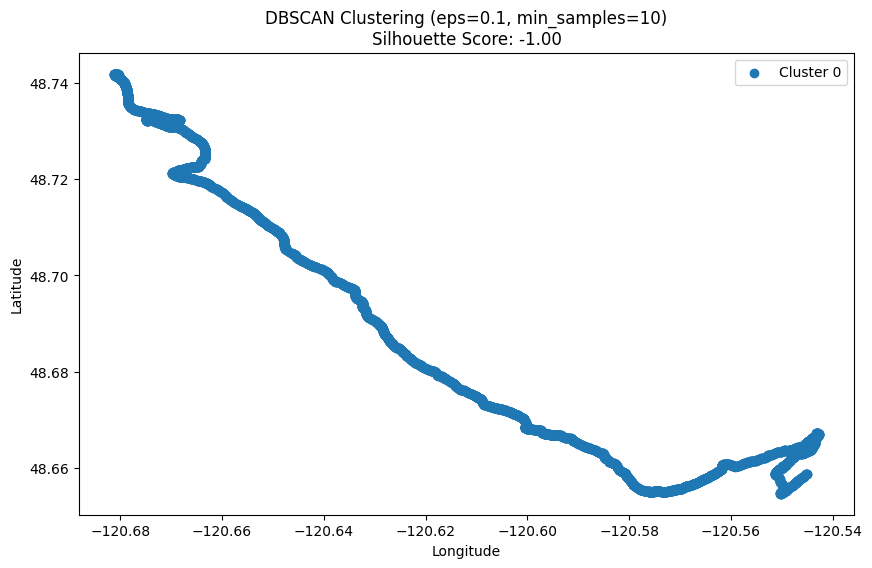

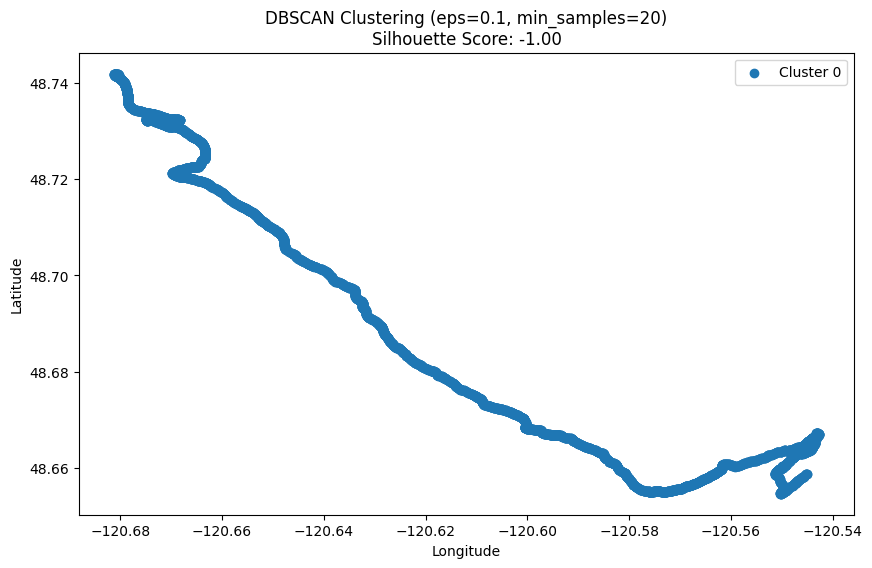

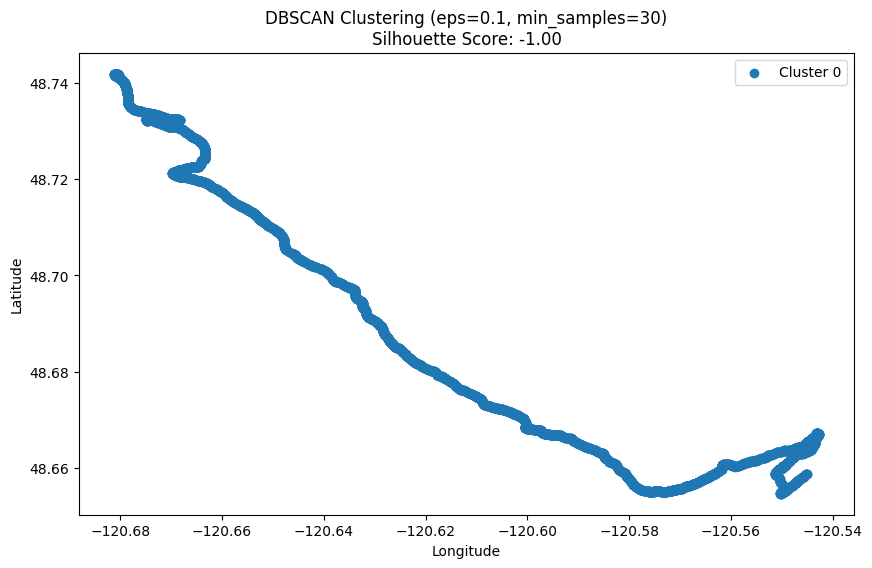

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np


# Combine lat, lon, altitude, gradient, and bearing for clustering
X = df[['lat', 'lon']].values

# Function to perform DBSCAN clustering and plot results
def perform_dbscan(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')
    df['cluster'] = dbscan.fit_predict(X)
    
    # Calculate silhouette score
    if len(set(df['cluster'])) > 1:
        score = silhouette_score(X, df['cluster'])
    else:
        score = -1  # Invalid score if only one cluster
    
    # Plot the clusters
    plt.figure(figsize=(10, 6))
    for cluster in np.unique(df['cluster']):
        clustered_data = df[df['cluster'] == cluster]
        plt.scatter(clustered_data['lon'], clustered_data['lat'], label=f'Cluster {cluster}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})\nSilhouette Score: {score:.2f}')
    plt.legend()
    plt.show()
    
    return score

# Experiment with different values of eps and min_samples
eps_values = [0.01, 0.05, 0.1]
min_samples_values = [10, 20, 30]

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        score = perform_dbscan(eps, min_samples)
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

print(f'Best Silhouette Score: {best_score:.2f} with eps={best_params[0]} and min_samples={best_params[1]}')

In [39]:
df

,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color,bearing,cardinal_direction,bearing_normalized,gradient_normalized,altitude_normalized,cluster,sequential_cluster
0,48.658872,-120.545005,797.6,NaN,NaN,0.000000,0.000000,NaN,0.000000,"[68, 1, 84, 255]",0.000000,N,0.000000,0.000000,0.000000,1,3
1,48.658834,-120.545067,798.0,-0.000038,-0.000062,8.081876,0.008082,0.4,4.949346,"[68, 1, 84, 255]",227.142380,SW,0.630951,0.061499,0.000270,0,2
2,48.658796,-120.545123,798.4,-0.000038,-0.000056,7.521409,0.015603,0.4,5.318152,"[68, 1, 84, 255]",224.228633,SW,0.622857,0.066082,0.000539,0,2
3,48.658756,-120.545179,798.8,-0.000040,-0.000056,7.648431,0.023252,0.4,5.229831,"[68, 1, 84, 255]",222.761399,SW,0.618782,0.064984,0.000809,0,2
4,48.658716,-120.545234,799.4,-0.000040,-0.000055,7.558269,0.030810,0.6,7.938325,"[68, 1, 84, 255]",222.247194,SW,0.617353,0.098639,0.001213,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5
4106,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5
4107,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5
4108,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5


array([ 1,  0, -1,  2,  3], dtype=int64)

In [22]:
range(0, 10, 1)

range(0, 10)

In [27]:
df['cluster'].unique()

array([ 1,  0, -1,  2,  3], dtype=int64)

In [26]:
unique_clusters

{1: 0, 2: 1, 3: 2, 4: 3}

In [29]:
unique_clusters

{-1: 0, 0: 1, 1: 2, 2: 3, 3: 4}

In [36]:
df

,lat,lon,altitude,delta_lat,delta_lon,distance,cumulative_distance,delta_altitude,gradient,color,bearing,cardinal_direction,bearing_normalized,gradient_normalized,altitude_normalized,cluster,sequential_cluster
0,48.658872,-120.545005,797.6,NaN,NaN,0.000000,0.000000,NaN,0.000000,"[68, 1, 84, 255]",0.000000,N,0.000000,0.000000,0.000000,1,3
1,48.658834,-120.545067,798.0,-0.000038,-0.000062,8.081876,0.008082,0.4,4.949346,"[68, 1, 84, 255]",227.142380,SW,0.630951,0.061499,0.000270,0,2
2,48.658796,-120.545123,798.4,-0.000038,-0.000056,7.521409,0.015603,0.4,5.318152,"[68, 1, 84, 255]",224.228633,SW,0.622857,0.066082,0.000539,0,2
3,48.658756,-120.545179,798.8,-0.000040,-0.000056,7.648431,0.023252,0.4,5.229831,"[68, 1, 84, 255]",222.761399,SW,0.618782,0.064984,0.000809,0,2
4,48.658716,-120.545234,799.4,-0.000040,-0.000055,7.558269,0.030810,0.6,7.938325,"[68, 1, 84, 255]",222.247194,SW,0.617353,0.098639,0.001213,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5
4106,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5
4107,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5
4108,48.741671,-120.680934,2281.6,0.000000,0.000000,0.000000,26.362988,0.0,0.000000,"[253, 231, 36, 255]",0.000000,N,0.000000,0.000000,1.000000,3,5


In [ ]:
#if it's not too computationlly intensive, we can do this for each course that we pull in to optimize silhouette score for the data
#then we can plot out the clusters for each course and see if they make sense
#Lets try for a sample set of courses that are pretty diverse, then we can group the whole df by each of the clusters to smooth the optimization process a bunch
